<h2>Thư viện cần thiết<h2>

In [214]:
# <h2>Thư viện cần thiết<h2>
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

# Import sklearn libraries
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Import thêm các thư viện cần thiết cho EDA
from statsmodels.graphics.gofplots import qqplot
from IPython.display import display, HTML

# PyTorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Đặt seed cho reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Thiết lập phong cách cho Seaborn
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


<h2>DataLoader<h2>

In [215]:
# <h2>DataLoader<h2>
class CO2DataLoader:
    def __init__(self, filepath, window_size=5):
        self.filepath = filepath
        self.window_size = window_size
        self.raw_data = None  # Dữ liệu nguyên thủy
        self.data_interpolated = None  # Dữ liệu sau khi nội suy
        self.X = None
        self.y = None
        self.time_indices = None  # Thêm thuộc tính này để lưu thời gian

    def load_data(self):
        # Load dữ liệu
        data = pd.read_csv(self.filepath)
        data['time'] = pd.to_datetime(data['time'])
        data.set_index('time', inplace=True)
        self.raw_data = data.copy()
        print("Dữ liệu nguyên thủy đã được tải.")

    def show_raw_data_table(self):
        # Hiển thị dữ liệu nguyên thủy dưới dạng bảng đẹp mắt
        print("Bảng dữ liệu nguyên thủy:")
        styled_table = self.raw_data.head(10).style.set_properties(**{
            'background-color': '#f0f0f0',
            'color': '#000000',
            'border-color': 'black'
        }).set_table_styles([{
            'selector': 'th',
            'props': [('background-color', '#404040'), ('color', 'white')]
        }])
        display(styled_table)

    def interpolate_data(self):
        # Hàm nội suy giá trị thiếu
        self.data_interpolated = self.raw_data.copy()
        self.data_interpolated['co2'] = self.data_interpolated['co2'].interpolate()
        print("Đã nội suy dữ liệu.")

    def show_interpolated_data_chart(self):
        # Hiển thị dữ liệu sau khi nội suy dưới dạng biểu đồ đẹp
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=self.data_interpolated, x=self.data_interpolated.index, y='co2', color='blue')
        plt.xlabel('Time')
        plt.ylabel('CO2 Concentration')
        plt.title('Dữ liệu CO2 sau khi nội suy')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def create_sequences(self):
        # Tạo các sequence cho mô hình
        xs = []
        ys = []
        co2_values = self.data_interpolated['co2'].values
        for i in range(len(co2_values) - self.window_size):
            x_seq = co2_values[i:i + self.window_size]
            y_seq = co2_values[i + self.window_size]
            xs.append(x_seq)
            ys.append(y_seq)
        self.X = np.array(xs)
        self.y = np.array(ys)
        # Lưu lại time indices tương ứng với y
        self.time_indices = self.data_interpolated.index[self.window_size:]
        print("Đã tạo các sequence.")

    def show_sequence_data(self):
        # Hiển thị một vài sequence đầu tiên dưới dạng bảng đẹp
        print("5 sequence đầu tiên:")
        df_sequences = pd.DataFrame(self.X[:5], columns=[f'lag_{i + 1}' for i in range(self.window_size)])
        df_sequences['target'] = self.y[:5]
        styled_table = df_sequences.style.set_properties(**{
            'background-color': '#f9f9f9',
            'color': '#000000',
            'border-color': 'black'
        }).set_table_styles([{
            'selector': 'th',
            'props': [('background-color', '#333333'), ('color', 'white')]
        }])
        display(styled_table)

    def scale_data(self):
        # Hàm chuẩn hóa dữ liệu sử dụng StandardScaler
        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()

        self.X_scaled = self.x_scaler.fit_transform(self.X)
        self.y_scaled = self.y_scaler.fit_transform(self.y.reshape(-1, 1)).flatten()
        print("Dữ liệu đã được chuẩn hóa bằng StandardScaler.")

    def show_scaled_data(self):
        # Hiển thị một vài mẫu dữ liệu sau khi chuẩn hóa dưới dạng bảng đẹp
        print("5 mẫu dữ liệu sau khi chuẩn hóa:")
        df_scaled = pd.DataFrame(self.X_scaled[:5], columns=[f'lag_{i + 1}' for i in range(self.window_size)])
        df_scaled['target'] = self.y_scaled[:5]
        styled_table = df_scaled.style.background_gradient(cmap='Blues')
        display(styled_table)

    def split_data(self, train_ratio=0.8):
        total_samples = self.X.shape[0]
        train_size = int(total_samples * train_ratio)

        X_train = self.X[:train_size]
        y_train = self.y[:train_size]
        X_test = self.X[train_size:]
        y_test = self.y[train_size:]

        time_indices_train = self.time_indices[:train_size]
        time_indices_test = self.time_indices[train_size:]

        return X_train, y_train, X_test, y_test, time_indices_train, time_indices_test

    def split_scaled_data(self, train_ratio=0.8):
        total_samples = self.X_scaled.shape[0]
        train_size = int(total_samples * train_ratio)

        X_train_scaled = self.X_scaled[:train_size]
        y_train_scaled = self.y_scaled[:train_size]
        X_test_scaled = self.X_scaled[train_size:]
        y_test_scaled = self.y_scaled[train_size:]

        time_indices_train = self.time_indices[:train_size]
        time_indices_test = self.time_indices[train_size:]

        return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, time_indices_train, time_indices_test


<h2>EDA Class<h2>

In [216]:
# <h2>EDA Class<h2>
class EDA:
    def __init__(self, data):
        self.data = data

    def info(self):
        # Hiển thị thông tin tổng quan về dữ liệu
        print("Thông tin dữ liệu:")
        import io
        buffer = io.StringIO()
        self.data.info(buf=buffer)
        info_str = buffer.getvalue()
        display(HTML(f"<pre>{info_str}</pre>"))
        # In kích thước của dữ liệu
        print("\nKích thước dữ liệu (số dòng, số cột):")
        print(self.data.shape)
        # In các cột trong dữ liệu
        print("\nCác cột trong dữ liệu:")
        print(self.data.columns.tolist())

    def describe_data(self):
        # Hiển thị thống kê mô tả với định dạng đẹp
        description = self.data.describe()
        print("\nThống kê mô tả của dữ liệu:")
        styled_table = description.style.set_properties(**{
            'background-color': '#f9f9f9',
            'color': '#000000',
            'border-color': 'black'
        }).set_table_styles([{
            'selector': 'th',
            'props': [('background-color', '#333333'), ('color', 'white')]
        }])
        display(styled_table)

    def check_missing_values(self):
        # Hiển thị số lượng giá trị thiếu với định dạng đẹp
        missing_values = self.data.isnull().sum()
        df_missing = pd.DataFrame(missing_values, columns=['Missing Values'])
        styled_table = df_missing.style.highlight_null(color='red').set_properties(**{
            'background-color': '#f0f0f0',
            'color': '#000000',
            'border-color': 'black'
        })
        print("\nSố lượng giá trị thiếu trong dữ liệu:")
        display(styled_table)

    def plot_time_series(self):
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=self.data, x=self.data.index, y='co2', color='blue')
        plt.xlabel('Time')
        plt.ylabel('CO2 Concentration')
        plt.title('CO2 Concentration over Time')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_histogram(self, column='co2'):
        plt.figure(figsize=(8, 5))
        sns.histplot(self.data[column], bins=30, kde=True, color='skyblue')
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

    def plot_boxplot(self, column='co2'):
        plt.figure(figsize=(6, 4))
        sns.boxplot(y=self.data[column], color='lightgreen')
        plt.title(f'Boxplot of {column}')
        plt.ylabel(column)
        plt.tight_layout()
        plt.show()

    def plot_violinplot(self, column='co2'):
        plt.figure(figsize=(6, 4))
        sns.violinplot(y=self.data[column], color='lightcoral')
        plt.title(f'Violin Plot of {column}')
        plt.ylabel(column)
        plt.tight_layout()
        plt.show()

    def plot_density(self, column='co2'):
        plt.figure(figsize=(8, 5))
        sns.kdeplot(self.data[column], shade=True, color='purple')
        plt.title(f'Density Plot of {column}')
        plt.xlabel(column)
        plt.ylabel('Density')
        plt.tight_layout()
        plt.show()

    def plot_lag_plot(self, column='co2'):
        plt.figure(figsize=(6, 6))
        pd.plotting.lag_plot(self.data[column])
        plt.title(f'Lag Plot of {column}')
        plt.tight_layout()
        plt.show()

    def plot_qq(self, column='co2'):
        plt.figure(figsize=(6, 6))
        qqplot(self.data[column], line='s')
        plt.title(f'QQ Plot of {column}')
        plt.tight_layout()
        plt.show()


<h2>Model Class<h2>

<h3>Linear Regression<h3>

In [217]:
# <h2>Model Class<h2>
# <h3>Linear Regression<h3>
class LinearModel:
    def __init__(self):
        self.model = None
        self.best_params = None

    def train(self, X_train, y_train):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', None)
        ])

        param_grid = [
            {
                'regressor': [Ridge()],
                'regressor__alpha': [0.1, 1.0, 10.0]
            },
            {
                'regressor': [Lasso()],
                'regressor__alpha': [0.001, 0.01, 0.1]
            }
        ]

        tscv = TimeSeriesSplit(n_splits=5)

        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=tscv,
            scoring='r2',
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)
        self.model = grid_search.best_estimator_
        self.best_params = grid_search.best_params_
        print('Best parameters found for Linear Model:', self.best_params)
        print('Best R2 score (Cross-Validation):', grid_search.best_score_)

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, y_true, y_pred):
        r2 = r2_score(y_true, y_pred)
        print('Linear Model R2 Score:', r2)
        return r2


<h3>Random Forest<h3>

In [218]:
# <h3>Random Forest<h3>
class RandomForestModel:
    def __init__(self):
        self.model = None
        self.best_params = None

    def train(self, X_train, y_train):
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }

        tscv = TimeSeriesSplit(n_splits=5)

        rf = RandomForestRegressor(random_state=42)

        grid_search = GridSearchCV(
            estimator=rf,
            param_grid=param_grid,
            cv=tscv,
            scoring='r2',
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)
        self.model = grid_search.best_estimator_
        self.best_params = grid_search.best_params_
        print('Best parameters found for Random Forest:', self.best_params)
        print('Best R2 score (Cross-Validation):', grid_search.best_score_)

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, y_true, y_pred):
        r2 = r2_score(y_true, y_pred)
        print('Random Forest R2 Score:', r2)
        return r2


<h3>LSTM<h3>

In [219]:
# <h3>LSTM<h3>
class CO2Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # (samples, window_size)
        self.y = torch.tensor(y, dtype=torch.float32)  # (samples,)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, 1)
    def forward(self, x):
        x = x.unsqueeze(-1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.relu(self.fc1(out[:, -1, :]))
        out = self.fc2(out)
        return out.squeeze()



class DeepLearningModel:
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, learning_rate=0.001):
        self.model = LSTMModel(input_size, hidden_size, num_layers)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.train_losses = []

    def train(self, train_loader, num_epochs=50):
        for epoch in range(num_epochs):
            self.model.train()
            epoch_train_loss = 0
            for X_batch, y_batch in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
                epoch_train_loss += loss.item()
            avg_train_loss = epoch_train_loss / len(train_loader)
            self.train_losses.append(avg_train_loss)

            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            outputs = self.model(X_tensor)
        return outputs.numpy()

    def plot_losses(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.train_losses, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()
        plt.show()

    def evaluate(self, y_true, y_pred):
        r2 = r2_score(y_true, y_pred)
        print('Deep Learning Model R2 Score:', r2)
        return r2


<h2>Main<h2>

Hiển thị data và thống kê 

In [220]:
# Load data
data_loader = CO2DataLoader(filepath='./data_adjusted.csv', window_size=5)
data_loader.load_data()

Dữ liệu nguyên thủy đã được tải.


'Dữ liệu gốc dạng bảng'
Bảng dữ liệu nguyên thủy:


,co2
time,
1981-01-28 00:00:00,316.100000
1981-02-04 00:00:00,317.300000
1981-02-11 00:00:00,317.600000
1981-02-18 00:00:00,317.500000
1981-02-25 00:00:00,316.400000
1981-03-04 00:00:00,316.900000
1981-03-11 00:00:00,nan
1981-03-18 00:00:00,317.500000
1981-03-25 00:00:00,317.900000


'Đồ thị time series'


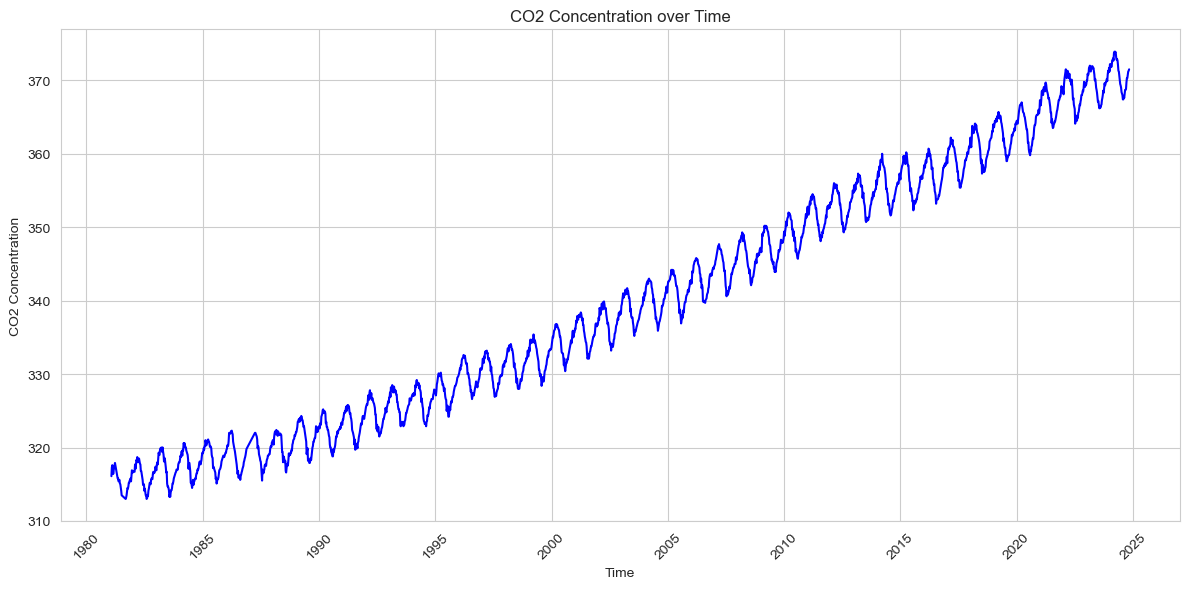

'Description'

Thống kê mô tả của dữ liệu:


,co2
count,2225.000000
mean,340.142247
std,17.003885
min,313.000000
25%,324.800000
50%,338.300000
75%,354.800000
max,373.900000


'Info dữ liệu'
Thông tin dữ liệu:



Kích thước dữ liệu (số dòng, số cột):
(2284, 1)

Các cột trong dữ liệu:
['co2']
None
'Missing'

Số lượng giá trị thiếu trong dữ liệu:


,Missing Values
co2,59


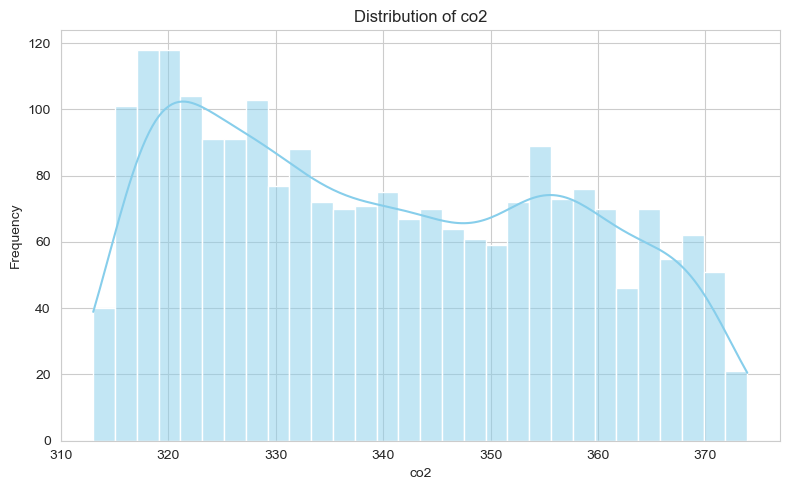

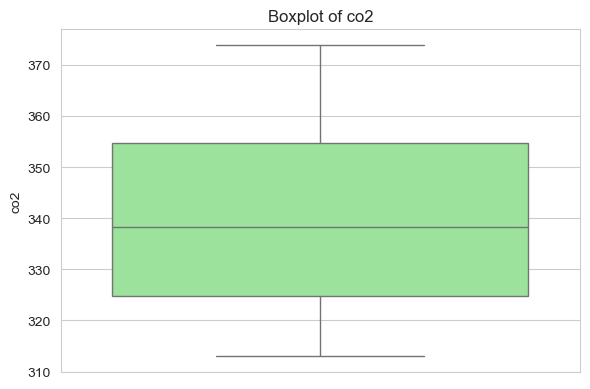

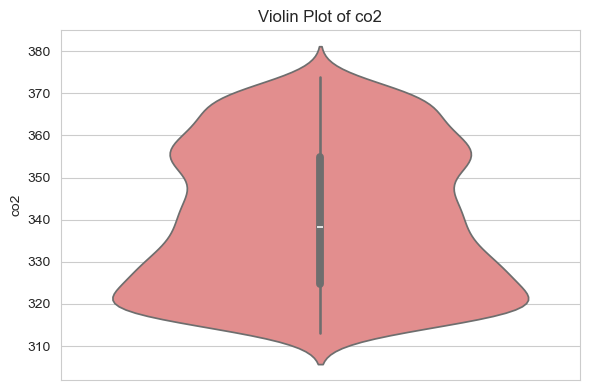

C:\Users\datha\AppData\Local\Temp\ipykernel_17092\1654951091.py:84: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




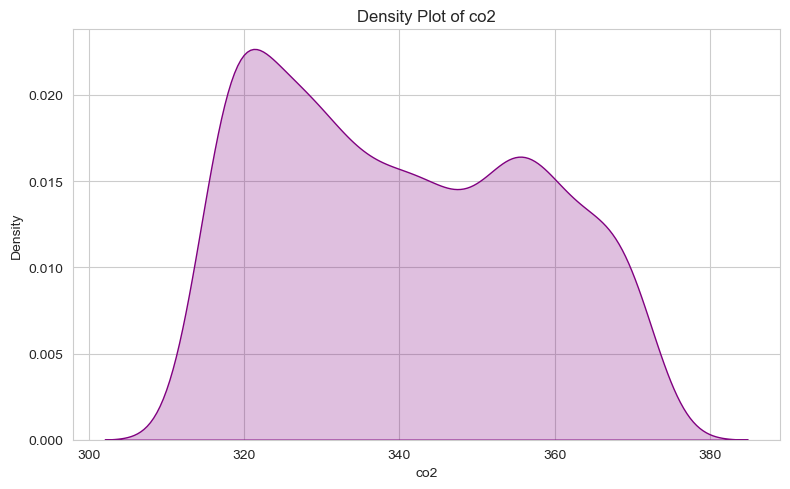

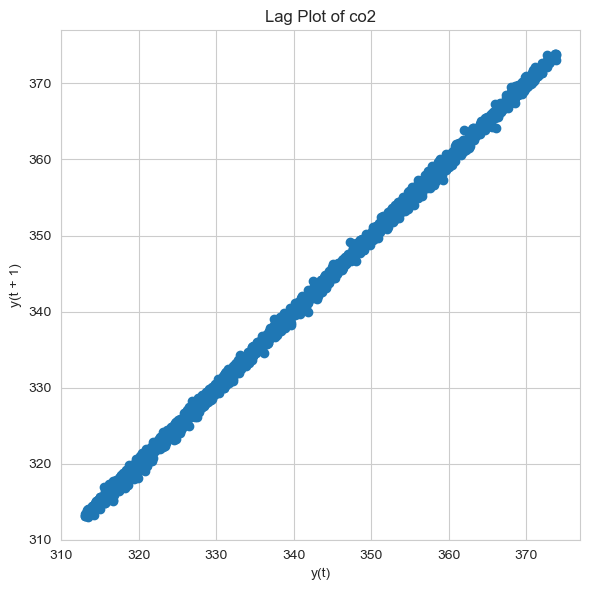

<Figure size 600x600 with 0 Axes>

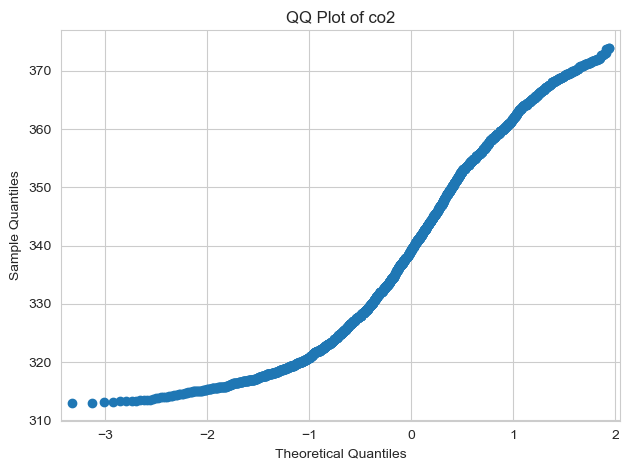

In [221]:
eda_raw = EDA(data_loader.raw_data)
pprint('Dữ liệu gốc dạng bảng')
data_loader.show_raw_data_table()
# Hiển thị dữ liệu gốc dạng đồ thị
pprint("Đồ thị time series")
eda_raw.plot_time_series()
# Mô tả dữ liệu nguyên thủy
pprint("Description")
eda_raw.describe_data()
pprint("Info dữ liệu")
print(eda_raw.info())
pprint("Missing")
eda_raw.check_missing_values()
eda_raw.plot_histogram()
eda_raw.plot_boxplot()
eda_raw.plot_violinplot()
eda_raw.plot_density()
# eda_raw.plot_autocorrelation()
# eda_raw.plot_partial_autocorrelation()
eda_raw.plot_lag_plot()
eda_raw.plot_qq()

'Sau nội suy'
Đã nội suy dữ liệu.


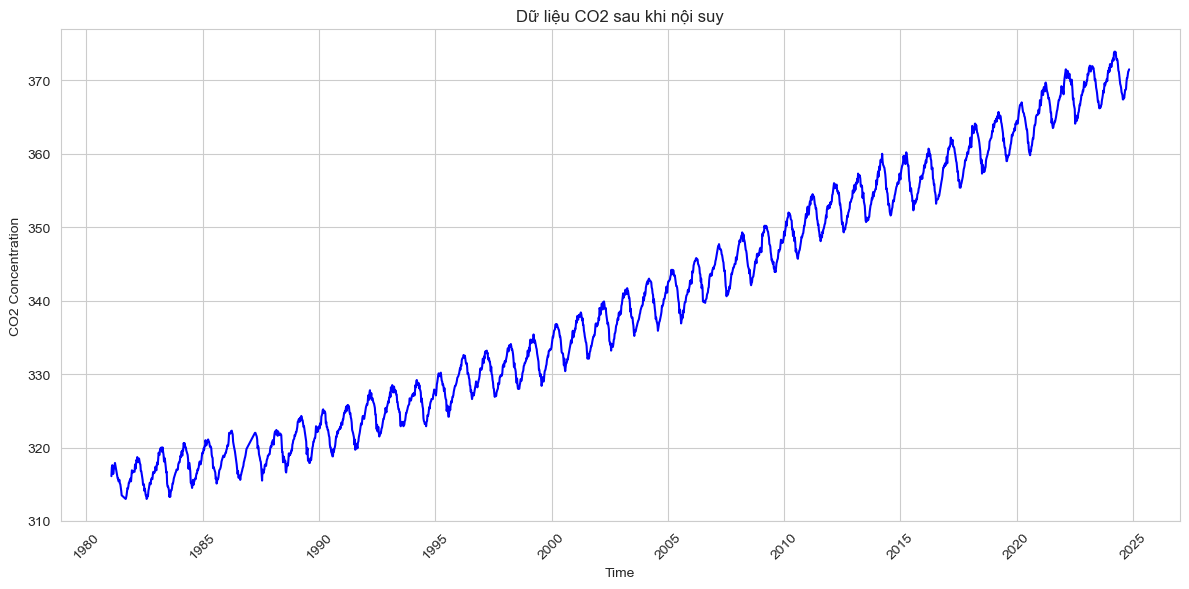

'Missing sau nội suy'

Số lượng giá trị thiếu trong dữ liệu:


,Missing Values
co2,0


In [222]:
# Nội suy dữ liệu
pprint("Sau nội suy")
data_loader.interpolate_data()
data_loader.show_interpolated_data_chart()
# EDA trên dữ liệu sau khi nội suy
pprint("Missing sau nội suy")
eda_interp = EDA(data_loader.data_interpolated)
eda_interp.check_missing_values()

In [223]:
# data khi sequence
pprint("Data khi sequence")
data_loader.create_sequences()     # Tạo sequence
data_loader.show_sequence_data()

'Data khi sequence'
Đã tạo các sequence.
5 sequence đầu tiên:


,lag_1,lag_2,lag_3,lag_4,lag_5,target
0,316.100000,317.300000,317.600000,317.500000,316.400000,316.900000
1,317.300000,317.600000,317.500000,316.400000,316.900000,317.200000
2,317.600000,317.500000,316.400000,316.900000,317.200000,317.500000
3,317.500000,316.400000,316.900000,317.200000,317.500000,317.900000
4,316.400000,316.900000,317.200000,317.500000,317.900000,317.550000


In [224]:
# data sau khi chuẩn hóa = standard scaler
pprint("Data khi chuẩn hóa")
data_loader.scale_data()
data_loader.show_scaled_data()

'Data khi chuẩn hóa'
Dữ liệu đã được chuẩn hóa bằng StandardScaler.
5 mẫu dữ liệu sau khi chuẩn hóa:


,lag_1,lag_2,lag_3,lag_4,lag_5,target
0,-1.376918,-1.307568,-1.290898,-1.297637,-1.362927,-1.334596
1,-1.306558,-1.289983,-1.296757,-1.362066,-1.333652,-1.317037
2,-1.288969,-1.295844,-1.361211,-1.332780,-1.316087,-1.299479
3,-1.294832,-1.360322,-1.331914,-1.315209,-1.298522,-1.276067
4,-1.359328,-1.331014,-1.314336,-1.297637,-1.275102,-1.296552


In [225]:
# Phân chia dữ liệu
X_train, y_train, X_test, y_test, time_indices_train, time_indices_test = data_loader.split_data(train_ratio=0.8)
X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, _, _ = data_loader.split_scaled_data(train_ratio=0.8)


In [226]:
# Training Linear Model với cross-validation
pprint("Training Linear Model")
lm = LinearModel()
lm.train(X_train, y_train)
# Dự đoán trên tập train và test
y_pred_lm_train = lm.predict(X_train)
y_pred_lm_test = lm.predict(X_test)
# Đánh giá mô hình
lm_r2_test = lm.evaluate(y_test, y_pred_lm_test)


'Training Linear Model'
Best parameters found for Linear Model: {'regressor': Ridge(), 'regressor__alpha': 0.1}
Best R2 score (Cross-Validation): 0.9759050483413161
Linear Model R2 Score: 0.99072721055977


In [227]:
# Training Random Forest Model với cross-validation
pprint("Training Random Forest Model")
rfm = RandomForestModel()
rfm.train(X_train, y_train)
# Dự đoán trên tập train và test
y_pred_rf_train = rfm.predict(X_train)
y_pred_rf_test = rfm.predict(X_test)
# Đánh giá mô hình
rf_r2_test = rfm.evaluate(y_test, y_pred_rf_test)


'Training Random Forest Model'
Best parameters found for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best R2 score (Cross-Validation): -0.02488431931404893
Random Forest R2 Score: -1.0463372932230057


In [228]:
# Chuẩn bị dữ liệu cho Deep Learning Model
train_dataset = CO2Dataset(X_train_scaled, y_train_scaled)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)


'Training Deep Learning Model'
Epoch [1/100], Train Loss: 0.6503
Epoch [2/100], Train Loss: 0.2808
Epoch [3/100], Train Loss: 0.0710
Epoch [4/100], Train Loss: 0.0159
Epoch [5/100], Train Loss: 0.0468
Epoch [6/100], Train Loss: 0.0969
Epoch [7/100], Train Loss: 0.0860
Epoch [8/100], Train Loss: 0.0264
Epoch [9/100], Train Loss: 0.0283
Epoch [10/100], Train Loss: 0.0329
Epoch [11/100], Train Loss: 0.0211
Epoch [12/100], Train Loss: 0.0112
Epoch [13/100], Train Loss: 0.0088
Epoch [14/100], Train Loss: 0.0074
Epoch [15/100], Train Loss: 0.0062
Epoch [16/100], Train Loss: 0.0050
Epoch [17/100], Train Loss: 0.0040
Epoch [18/100], Train Loss: 0.0031
Epoch [19/100], Train Loss: 0.0026
Epoch [20/100], Train Loss: 0.0024
Epoch [21/100], Train Loss: 0.0022
Epoch [22/100], Train Loss: 0.0022
Epoch [23/100], Train Loss: 0.0022
Epoch [24/100], Train Loss: 0.0023
Epoch [25/100], Train Loss: 0.0024
Epoch [26/100], Train Loss: 0.0024
Epoch [27/100], Train Loss: 0.0024
Epoch [28/100], Train Loss: 0.002

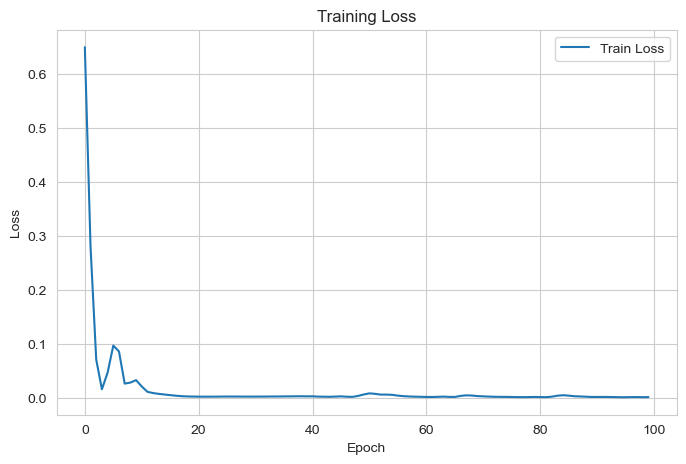

Deep Learning Model R2 Score: 0.9867336355161325
Deep Learning Model R2 Score: 0.988561383008845


In [229]:
# Training Deep Learning Model
pprint("Training Deep Learning Model")
dlm = DeepLearningModel()
dlm.train(train_loader, num_epochs=100)
dlm.plot_losses()
# Dự đoán trên tập train
y_pred_dl_train_scaled = dlm.predict(X_train_scaled)
# Dự đoán trên tập test
y_pred_dl_test_scaled = dlm.predict(X_test_scaled)
# Chuyển đổi ngược lại giá trị dự đoán và thực tế
y_pred_dl_train = data_loader.y_scaler.inverse_transform(y_pred_dl_train_scaled.reshape(-1, 1)).flatten()
y_pred_dl_test = data_loader.y_scaler.inverse_transform(y_pred_dl_test_scaled.reshape(-1, 1)).flatten()
# Đánh giá mô hình
dl_r2_train = dlm.evaluate(y_train, y_pred_dl_train)
dl_r2_test = dlm.evaluate(y_test, y_pred_dl_test)


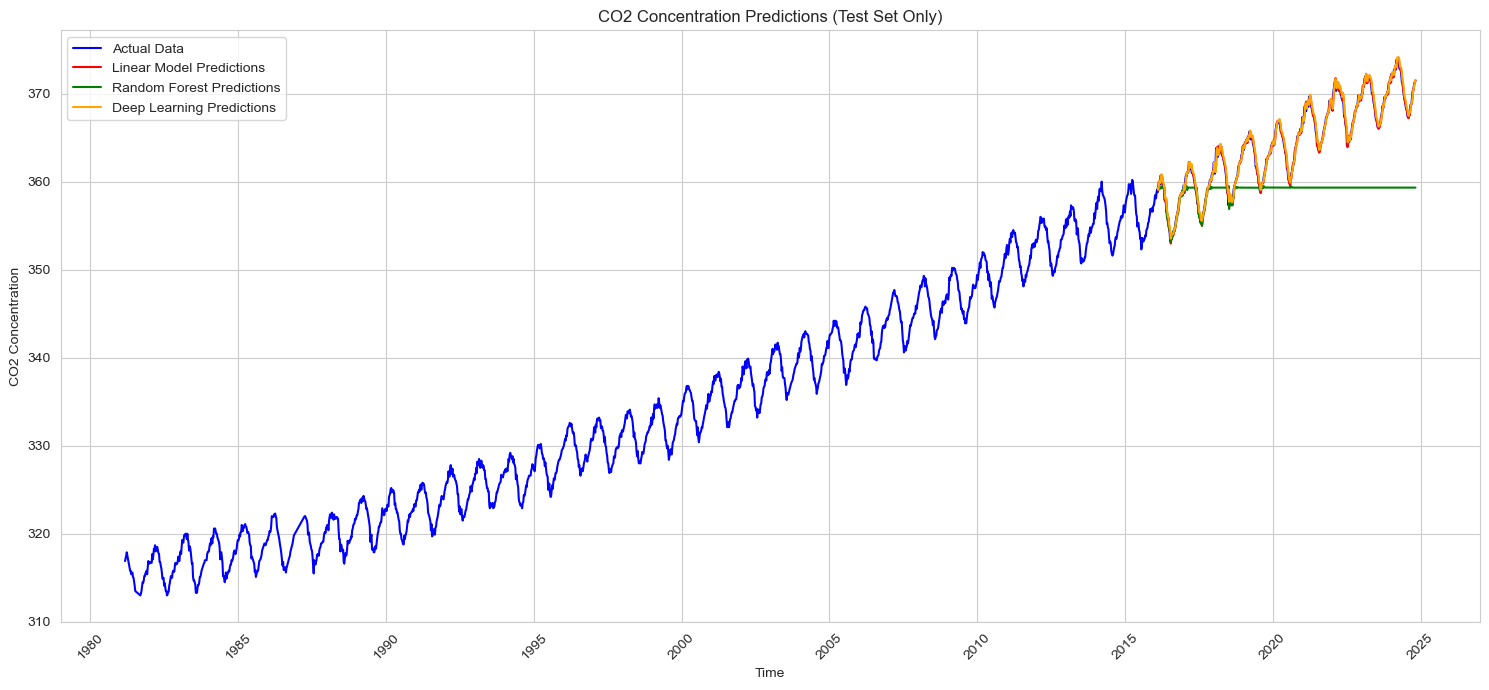

In [230]:
# Tạo các mảng dự đoán chỉ cho tập test và đặt NaN cho tập training
y_pred_lm = np.concatenate([ [np.nan]*len(y_train), y_pred_lm_test ])
y_pred_rf = np.concatenate([ [np.nan]*len(y_train), y_pred_rf_test ])
y_pred_dl = np.concatenate([ [np.nan]*len(y_train), y_pred_dl_test ])

# Kết hợp các chỉ số thời gian và giá trị thực
df_results = pd.DataFrame({
    'Time': np.concatenate([time_indices_train, time_indices_test]),
    'Actual': np.concatenate([y_train, y_test]),
    'LinearModel': y_pred_lm,
    'RandomForestModel': y_pred_rf,
    'DeepLearningModel': y_pred_dl
})

# Trực quan hóa kết quả
plt.figure(figsize=(15, 7))
plt.plot(df_results['Time'], df_results['Actual'], label='Actual Data', color='blue')

# Vẽ chỉ dự đoán từ tập test (các giá trị khác NaN)
plt.plot(df_results['Time'], df_results['LinearModel'], label='Linear Model Predictions', color='red')
plt.plot(df_results['Time'], df_results['RandomForestModel'], label='Random Forest Predictions', color='green')
plt.plot(df_results['Time'], df_results['DeepLearningModel'], label='Deep Learning Predictions', color='orange')

plt.xlabel('Time')
plt.ylabel('CO2 Concentration')
plt.title('CO2 Concentration Predictions (Test Set Only)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()